In [1]:
# !pip install transformers
!pip install simpletransformers

     |████████████████████████████████| 249 kB 5.4 MB/s 
     |████████████████████████████████| 1.2 MB 31.3 MB/s 
     |████████████████████████████████| 10.1 MB 30.8 MB/s 
     |████████████████████████████████| 1.8 MB 30.3 MB/s 
     |████████████████████████████████| 325 kB 46.4 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 6.6 MB 30.5 MB/s 
     |████████████████████████████████| 4.0 MB 20.8 MB/s 
     |████████████████████████████████| 596 kB 31.8 MB/s 
     |████████████████████████████████| 77 kB 2.2 MB/s 
     |████████████████████████████████| 895 kB 31.9 MB/s 
     |████████████████████████████████| 144 kB 31.6 MB/s 
     |████████████████████████████████| 181 kB 37.2 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 212 kB 33.3 MB/s 
     |████████████████████████████████| 1.1 MB 26.3 MB/s 
     |████████████████████████████████| 136 kB 18.0 MB/s 
     |██████████████

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import torchtext
import torch
from torch import nn
import json, re, unicodedata, string, typing, time
import torch.nn.functional as F
import spacy
from collections import Counter
import pickle
from nltk import word_tokenize
nlp = spacy.load('en')
os.chdir("/content/drive/MyDrive/Data2")
from torch import Tensor, nn, optim
from tqdm import tqdm
from simpletransformers.language_representation import RepresentationModel

In [ ]:
train_data = pd.read_json("train.jsonl",lines = True)
print(train_data.shape[0])
val_data = pd.read_json("dev.jsonl",lines = True)
test_data = pd.read_json("test.jsonl",lines = True)
# train_data.head(), train_data.head()

9427


In [ ]:
# val_data.shape,test_data.shape,train_data.shape

In [ ]:
import logging
logging.disable(logging.WARNING) 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
model = RepresentationModel(
        model_type='bert',
        model_name = 'bert-base-uncased',
        use_cuda=True
)
combined = train_data[['passage','question']]
combined_val = val_data[['passage','question']]
combined_test = test_data[['passage','question']]
batch_embeddings = []
batch_embeddings_val = []
batch_embeddings_test = []
for combi in combined.iterrows():
    batch_embeddings.append([combi[1]['passage'], combi[1]['question']])
    # print(batch_embeddings)

for combi in combined_val.iterrows():
    batch_embeddings_val.append([combi[1]['passage'], combi[1]['question']])
  
for combi in combined_test.iterrows():
    batch_embeddings_test.append([combi[1]['passage'], combi[1]['question']])
  

embeddings = model.encode_sentences( batch_embeddings, batch_size=1000, combine_strategy=None)
embeddings_val = model.encode_sentences( batch_embeddings_val, batch_size=1000, combine_strategy=None)
embeddings_test = model.encode_sentences( batch_embeddings_test, batch_size=1000, combine_strategy=None)
# print(embeddings.shape)
embeddings = torch.as_tensor(embeddings)
embeddings_val = torch.as_tensor(embeddings_val)
embeddings_test = torch.as_tensor(embeddings_test)


In [ ]:
# # embeddings_val.shape,embeddings_test.shape,embeddings.shape
# embeddings.shape

In [ ]:
# import gc
# gc.collect()

In [ ]:
# with open("train_embeddings_bert_pt2.pkl","wb") as fl:
#   pickle.dump(embeddings,fl)

In [ ]:
# with open("test_embeddings_bert.pkl","wb") as fl:
#   pickle.dump(embeddings_test,fl)

In [ ]:
# with open("val_embeddings_bert.pkl","wb") as fl:
#   pickle.dump(embeddings_val,fl)

In [ ]:
class QATransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int = 6,
        dim_model: int = 768,
        num_heads: int = 6,
        dim_feedforward: int = 2100,
        dropout: float = 0.,
    ):
        super().__init__()
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim_model, 
                                                                                nhead=num_heads, 
                                                                                dim_feedforward=dim_feedforward, 
                                                                                dropout=dropout), 
                                                                                num_layers = num_encoder_layers)
        self.linear_layer_1 = nn.Linear(dim_model, dim_model)
        self.linear_layer_2 = nn.Linear(dim_model, dim_model)
        self.linear_layer_3 = nn.Linear(dim_model*128, 1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, embedding) -> Tensor:
        # print(context.type(), question.type())
        transformer_output = self.encoder(embedding)
        transformer_output = F.relu(self.linear_layer_1(transformer_output))
        transformer_output = F.relu(self.linear_layer_2(transformer_output))
        output = self.linear_layer_3(transformer_output.flatten(start_dim = 1))
        output = output.mean(axis=1)
        return torch.sigmoid(output).squeeze()

In [ ]:
with open("train_embeddings_bert_pt1.pkl","rb") as fl:
  embeddings_1 = pickle.load(fl)
with open("train_embeddings_bert_pt2.pkl","rb") as fl:
  embeddings_2 = pickle.load(fl)
embeddings = torch.vstack((embeddings_1,embeddings_2))
with open("test_embeddings_bert.pkl","rb") as fl:
  embeddings = pickle.load(fl)
with open("val_embeddings_bert.pkl","rb") as fl:
  embeddings = pickle.load(fl)

In [ ]:
ind = np.random.permutation(np.arange(6000))
train_ind = ind[:(6000-512)]
test_ind = ind[-512:-256]
val_ind = ind[-256:]

In [ ]:
test_embeddings = embeddings[test_ind.tolist()]
val_embeddings = embeddings[val_ind.tolist()]
embeddings = embeddings[train_ind.tolist()]

In [ ]:
if torch.cuda.is_available():
  embeddings = embeddings.to('cuda')
  val_embeddings = val_embeddings.to('cuda')
  test_embeddings = test_embeddings.to('cuda')

In [ ]:
embeddings.shape,test_embeddings.shape,val_embeddings.shape

(torch.Size([5488, 128, 768]),
 torch.Size([256, 128, 768]),
 torch.Size([256, 128, 768]))

In [ ]:
# embeddings.shape

In [ ]:
train_data.shape

(9427, 4)

In [ ]:
test_data = train_data.iloc[test_ind]
val_data=  train_data.iloc[val_ind]
train_data = train_data.iloc[train_ind]
train_data.shape,val_data.shape,test_data.shape

((5488, 4), (256, 4), (256, 4))

# Train model

In [ ]:
net = QATransformer()
if torch.cuda.is_available():
    net = net.to("cuda")
optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay = 1e-6)
criterion = nn.BCELoss()
criterion_val = nn.BCELoss()
if torch.cuda.is_available():
    criterion = criterion.to("cuda")
loss_array = []
acc = []
acc_val = []
epochs=20
batch_size=32
loss_val_array =[]
for epoch in tqdm(range(epochs)):
    running_loss = 0
    encodings_arr = []
    for index in range(embeddings.shape[0]//batch_size):
        idx_start = index*batch_size
        idx_end = (index+1)*batch_size
        optimizer.zero_grad()
        emb = embeddings[idx_start:idx_end]
        label = torch.as_tensor(train_data.iloc[idx_start:idx_end]['answer'].tolist()).float()
        if torch.cuda.is_available():
            label = label.to("cuda")
        output = net(emb)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()*batch_size
    loss_array.append(running_loss/train_data.shape[0])
    pred = []
    pred_val = []
    for index in range(embeddings.shape[0]//batch_size):
        idx_start = index*batch_size
        idx_end = (index+1)*batch_size
        out = net(embeddings[idx_start:idx_end])
        # out_val = net(val_embeddings)
        label = torch.as_tensor(train_data.iloc[idx_start:idx_end]['answer'].tolist()).float()
        if torch.cuda.is_available():
            label = label.to("cuda")
        pred.extend((torch.round(out) > 0.5).int() == label)
        # pred_val.extend((torch.round(out_val) > 0.5).int() == label_val)
    running_loss_val = 0
    
    for index in range(val_embeddings.shape[0]//batch_size):
        idx_start = index*batch_size
        idx_end = (index+1)*batch_size
        # out = net(embeddings[idx_start:idx_end])
        out_val = net(val_embeddings[idx_start:idx_end])
        label = torch.as_tensor(val_data.iloc[idx_start:idx_end]['answer'].tolist()).float()
        if torch.cuda.is_available():
            label = label.to("cuda")
        loss_val = criterion_val(out_val,label)
        running_loss_val +=loss_val.item()*batch_size
        pred_val.extend((torch.round(out_val) > 0.5).int() == label)
    loss_val_array.append(running_loss_val/val_data.shape[0])

    pred = torch.as_tensor(pred)
    pred_val = torch.as_tensor(pred_val)
    curr_acc = pred.sum()/pred.shape[0]
    curr_acc_val = pred_val.sum()/pred_val.shape[0]
    acc.append(curr_acc)
    acc_val.append(curr_acc_val)
    print(loss_array[-1], acc[-1], acc_val[-1],loss_val_array[-1])

    # if len(acc_val)>=2 and acc_val[-1] < acc_val[-2]:
    #   break

  5%|▌         | 1/20 [01:05<20:36, 65.09s/it]

0.6633267173266619 tensor(0.6254) tensor(0.6055) 0.6801837831735611


 10%|█         | 2/20 [02:09<19:22, 64.60s/it]

0.6521401040408076 tensor(0.6254) tensor(0.6055) 0.6786369159817696


 15%|█▌        | 3/20 [03:14<18:19, 64.66s/it]

0.6330329947846971 tensor(0.6272) tensor(0.6055) 0.676762156188488


 20%|██        | 4/20 [04:18<17:13, 64.60s/it]

0.6026966856798 tensor(0.6835) tensor(0.6172) 0.6716637909412384


 25%|██▌       | 5/20 [05:23<16:09, 64.64s/it]

0.563332924342364 tensor(0.7800) tensor(0.6094) 0.6685197055339813


 30%|███       | 6/20 [06:28<15:05, 64.70s/it]

0.5168131586414036 tensor(0.8220) tensor(0.6016) 0.6633111536502838


 35%|███▌      | 7/20 [07:33<14:01, 64.76s/it]

0.468226135124618 tensor(0.8474) tensor(0.6055) 0.6623466908931732


 40%|████      | 8/20 [08:37<12:58, 64.84s/it]

0.4192329215933908 tensor(0.8818) tensor(0.6094) 0.6653573140501976


 45%|████▌     | 9/20 [09:43<11:53, 64.90s/it]

0.3767197927128817 tensor(0.8947) tensor(0.6289) 0.6689045280218124


 50%|█████     | 10/20 [10:48<10:49, 64.93s/it]

0.35355464944686554 tensor(0.8533) tensor(0.6328) 0.7357455492019653


 55%|█████▌    | 11/20 [11:52<09:43, 64.89s/it]

0.3215330830468381 tensor(0.8171) tensor(0.6328) 0.8317905738949776


 60%|██████    | 12/20 [12:57<08:38, 64.82s/it]

0.27851512506821413 tensor(0.7504) tensor(0.6328) 0.9811337664723396


 65%|██████▌   | 13/20 [14:02<07:33, 64.76s/it]

0.2536028431125702 tensor(0.8090) tensor(0.6328) 0.9149765223264694


 70%|███████   | 14/20 [15:06<06:28, 64.76s/it]

0.21876043680805507 tensor(0.9764) tensor(0.6055) 0.7396883964538574


 75%|███████▌  | 15/20 [16:11<05:24, 64.81s/it]

0.18195242102396383 tensor(0.9815) tensor(0.5938) 0.7666517347097397


 80%|████████  | 16/20 [17:16<04:19, 64.85s/it]

0.13881216152590148 tensor(0.9826) tensor(0.5938) 0.8250368386507034


 85%|████████▌ | 17/20 [18:21<03:14, 64.90s/it]

0.10435804283740568 tensor(0.9644) tensor(0.6172) 0.9613630697131157


 90%|█████████ | 18/20 [19:26<02:09, 64.96s/it]

0.08375530389107698 tensor(0.9306) tensor(0.6250) 1.1558124274015427


 95%|█████████▌| 19/20 [20:31<01:04, 64.90s/it]

0.06612323238663702 tensor(0.9466) tensor(0.6211) 1.1724655479192734


100%|██████████| 20/20 [21:36<00:00, 64.82s/it]

0.050343104619152694 tensor(0.9770) tensor(0.6055) 1.1562847346067429


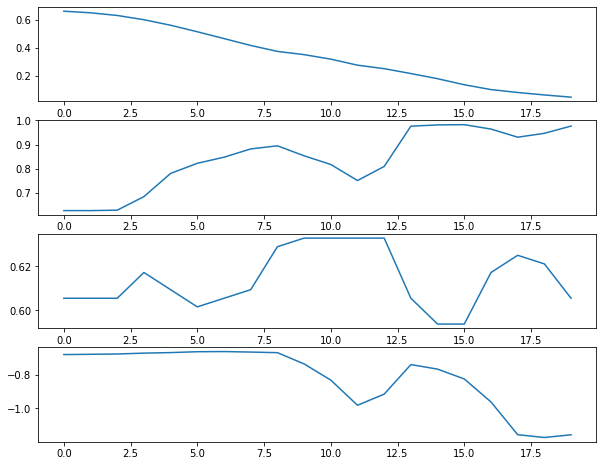

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))

plt.subplot(4,1,1)
plt.plot(loss_array)

plt.subplot(4,1,2)
plt.plot(acc)

plt.subplot(4,1,3)
plt.plot(acc_val)

plt.subplot(4,1,4)
plt.plot(np.array(loss_val_array) * -1)
plt.show()

In [ ]:
# with open("final_model_2816_train_256_test_train_loss_array.pkl","wb") as fl:
#   pickle.dump(loss_array,fl)
# with open("final_model_2816_train_256_test_train_accuracy_array.pkl","wb") as fl:
#   pickle.dump(acc,fl)

In [ ]:
# with open("final_model_5488_train_1.pkl","wb") as fl:
#   pickle.dump(net,fl)

In [ ]:
with open("final_model_5488_train_1.pkl","rb") as fl:
  net = pickle.load(fl)

# Load saved model

In [ ]:
# with open("final_model_1792_train_256_test.pkl","rb") as fle:
#   net2 = pickle.load(fle)
# net2.to('cuda')

In [ ]:
torch.no_grad()
torch.cuda.empty_cache()

# Test accuracy

In [ ]:
pred = net(test_embeddings)
x = (pred>= 0.5).int()
label = torch.as_tensor(test_data['answer'].tolist()).int().to('cuda')
acc = (x == label).sum() / label.shape[0]
acc

tensor(0.8867, device='cuda:0')

In [ ]:
label = label.to('cpu')
x = x.to('cpu')

In [ ]:
label = np.array(label)
x = np.array(x)

## F1- Score

In [ ]:
from sklearn.metrics import f1_score
f1_score(label,x)

0.9169054441260746

# Save model

In [ ]:
with open("final_model_2816_train_model.pkl","wb") as fle:
  pickle.dump(net,fle)